In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
%matplotlib inline  

In [2]:
use_cuda = True
batch_size = 32
latent_size = 20 # z dim

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False,
                       transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)


In [3]:
def to_var(x):
    x = Variable(x)
    if use_cuda:
        x = x.cuda()
    return x

def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return to_var(targets)

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), size_average=False)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [4]:
class CVAE(nn.Module):
    def __init__(self, feature_size, latent_size, class_size):
        super(CVAE, self).__init__()
        self.feature_size = feature_size
        self.class_size = class_size

        # encode
        self.fc1  = nn.Linear(feature_size + class_size, 400)
        self.fc21 = nn.Linear(400, latent_size)
        self.fc22 = nn.Linear(400, latent_size)

        # decode
        self.fc3 = nn.Linear(latent_size + class_size, 400)
        self.fc4 = nn.Linear(400, feature_size)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x, c): # Q(z|x, c)
        '''
        x: (bs, feature_size)
        c: (bs, class_size)
        '''
        inputs = torch.cat([x, c], 1) # (bs, feature_size+class_size)
        h1 = self.relu(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def reparametrize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std) + mu
        else:
            return mu

    def decode(self, z, c): # P(x|z, c)
        '''
        z: (bs, latent_size)
        c: (bs, class_size)
        '''
        inputs = torch.cat([z, c], 1) # (bs, latent_size+class_size)
        h3 = self.relu(self.fc3(inputs))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x, c):
        mu, logvar = self.encode(x.view(-1, 28*28), c)
        z = self.reparametrize(mu, logvar)
        return self.decode(z, c), mu, logvar


In [5]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = to_var(data)
        labels = one_hot(labels, 10)
        recon_batch, mu, logvar = model(data, labels)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))

def test(epoch):
    model.eval()
    test_loss = 0
    for i, (data, labels) in enumerate(test_loader):
        data = to_var(data)
        labels = one_hot(labels, 10)
        recon_batch, mu, logvar = model(data, labels)
        test_loss += loss_function(recon_batch, data, mu, logvar).data[0]
        if i == 0:
            n = min(data.size(0), 8)
            comparison = torch.cat([data[:n],
                                  recon_batch.view(batch_size, 1, 28, 28)[:n]])
            save_image(comparison.data.cpu(),
                     'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [6]:
model = CVAE(28*28, latent_size, 10)
if use_cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
for epoch in range(1, 11):
    train(epoch)
#     test(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 547.359741
Train Epoch: 1 [16000/60000 (27%)]	Loss: 132.207703
Train Epoch: 1 [32000/60000 (53%)]	Loss: 117.402779
Train Epoch: 1 [48000/60000 (80%)]	Loss: 113.309448
Train Epoch: 2 [0/60000 (0%)]	Loss: 106.266098
Train Epoch: 2 [16000/60000 (27%)]	Loss: 110.836258
Train Epoch: 2 [32000/60000 (53%)]	Loss: 105.291489
Train Epoch: 2 [48000/60000 (80%)]	Loss: 104.185242
Train Epoch: 3 [0/60000 (0%)]	Loss: 100.511154
Train Epoch: 3 [16000/60000 (27%)]	Loss: 102.067039
Train Epoch: 3 [32000/60000 (53%)]	Loss: 106.235672
Train Epoch: 3 [48000/60000 (80%)]	Loss: 107.444717
Train Epoch: 4 [0/60000 (0%)]	Loss: 108.529533
Train Epoch: 4 [16000/60000 (27%)]	Loss: 105.664978
Train Epoch: 4 [32000/60000 (53%)]	Loss: 104.566406
Train Epoch: 4 [48000/60000 (80%)]	Loss: 97.197411
Train Epoch: 5 [0/60000 (0%)]	Loss: 108.291611
Train Epoch: 5 [16000/60000 (27%)]	Loss: 103.966408
Train Epoch: 5 [32000/60000 (53%)]	Loss: 95.879662
Train Epoch: 5 [48000/60000 (80%)]	Loss

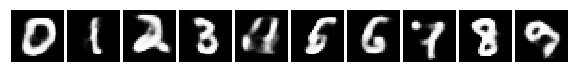

In [8]:
# Generate images with condition labels
c = torch.eye(10, 10) # [one hot labels for 0-9]
c = to_var(c)
z = to_var(torch.randn(10, latent_size))
samples = model.decode(z, c).data.cpu().numpy()

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10)
gs.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')